In [26]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ks_2samp
from scipy.optimize import curve_fit
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm
import datetime
import itertools
from itertools import permutations

import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load Data

In [20]:
# start from original data
df100 = pd.read_csv('../data/tfrrs_scraped.csv')

# keep only running events
running_events = ['100', '200', '400', '800', '1500', '5000', '10000', '100H',
       '110H', '400H', '3000S', '4x100', '4x400']
df100 = df100[df100['EVENT'].isin(running_events)]

# df100 = df100[df100['DIVISION'].isin(['D1', 'D2'])]

# list of groups and avg time_secs
avg_list = []
for group in df100.groupby(['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX']):
    avg_list.append([group[0], group[1].TIME_SECS.mean()])
    
# split group tuple back into year/division/event/sex columns and drop group tuple
df_grouped = pd.DataFrame(avg_list, columns = ['GROUP', 'TIME_SECS_AVG'])
df_grouped[['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX']] = pd.DataFrame(df_grouped['GROUP'].tolist(), index=df_grouped.index)
df_grouped = df_grouped[['CHAMP_YEAR', 'DIVISION', 'EVENT', 'SEX', 'TIME_SECS_AVG']]

In [21]:
# list of dfs for each division/event/sex group
df_list = [group[1].reset_index() for group in df_grouped.groupby(['DIVISION', 'EVENT', 'SEX'])]

# for each df, rescale the TIME_SECS column by dividing all by the 2010 avg
avg_2010 = [df['TIME_SECS_AVG'][0] for df in df_list]
for df,avg in zip(df_list,avg_2010):
    df['TIME_SECS_SCALED'] = df['TIME_SECS_AVG']/avg
    
# concat back into one df
df_scaled = pd.concat(df_list).reset_index()
df_scaled.drop(['level_0','index'], axis=1, inplace=True)

In [22]:
# add treat, after and treatafter variable to the df
distance = ['800', '1500', '5000', '10000', '3000S']
treat_list = [1 if event in distance else 0 for event in df_scaled['EVENT']]
df_scaled['TREAT'] = treat_list
df_scaled['AFTER'] = df_scaled['CHAMP_YEAR'] >= 2021
df_scaled['TREAT_AFTER'] = df_scaled['AFTER']*df_scaled['TREAT']

In [23]:
# create synthetic control for 2010-2019, non weighted scaled average for each year for non-treated groups
control_df = df_scaled[(df_scaled['TREAT'] == 0) & (df_scaled['CHAMP_YEAR'] < 2021)]

sc = pd.DataFrame([[group[0], group[1]['TIME_SECS_SCALED'].mean()] for group in control_df.groupby('CHAMP_YEAR')], columns=['CHAMP_YEAR', 'AVG_SCALED_SECS'])

In [41]:
# run log transformed regression to predict
xs = np.array(sc.CHAMP_YEAR).reshape(-1, 1)
log_ys = [np.log(x) for x in sc.AVG_SCALED_SECS]

reg = LinearRegression().fit(xs, log_ys)
pred = np.exp(reg.predict(np.array(2021).reshape(-1,1))[0])

# Create a new row as a DataFrame and concatenate
new_row = pd.DataFrame({'CHAMP_YEAR': [2021], 'AVG_SCALED_SECS': [pred]})
sc = pd.concat([sc, new_row], ignore_index=True)

sc['CHAMP_YEAR'] = sc['CHAMP_YEAR'].astype(int)
print(sc)

    CHAMP_YEAR  AVG_SCALED_SECS
0         2010         1.000000
1         2011         0.995248
2         2012         0.992034
3         2013         0.993213
4         2014         0.991738
5         2015         0.989422
6         2016         0.988564
7         2017         0.987030
8         2018         0.987340
9         2019         0.987927
10        2021         0.983199


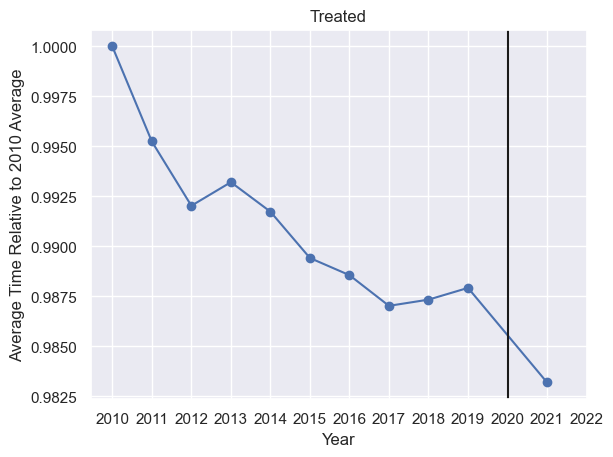

In [43]:
plt.plot(sc.CHAMP_YEAR, sc.AVG_SCALED_SECS, '-o');
plt.axvline(x=2020, color = 'k')
plt.title('Treated')
plt.xticks([2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022])
plt.xlabel('Year')
plt.ylabel('Average Time Relative to 2010 Average')
plt.show()

In [44]:
#create list of dfs for treated groups and control groups
treat_df = df_scaled[df_scaled['TREAT'] == 1]
control_df = df_scaled[df_scaled['TREAT'] == 0]

treat_list = [group[1] for group in treat_df.groupby(['DIVISION', 'EVENT', 'SEX'])]
control_list = [group[1] for group in control_df.groupby(['DIVISION', 'EVENT', 'SEX'])]

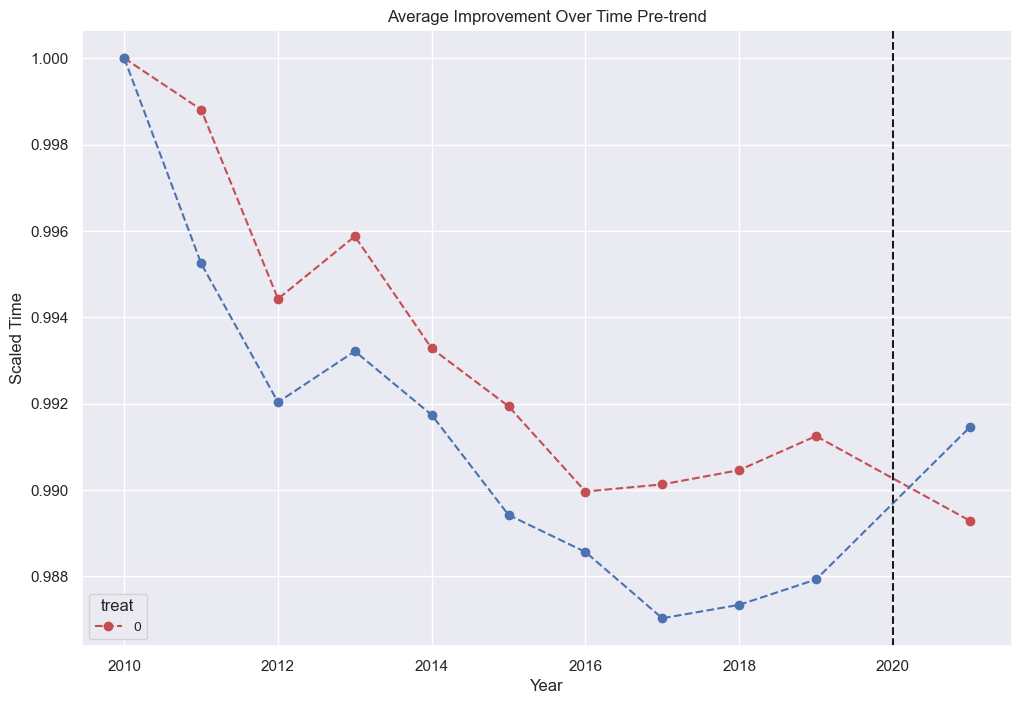

In [51]:
# plot scaled trends for synthetic control and averaged treated for pre-2021
t = []
c = []

for group in treat_df.groupby('CHAMP_YEAR'):
    t.append([group[0], group[1]['TIME_SECS_SCALED'].mean()])

for group in control_df.groupby('CHAMP_YEAR'):
    c.append([group[0], group[1]['TIME_SECS_SCALED'].mean()])

t_df = pd.DataFrame(t, columns=['CHAMP_YEAR', 'AVG_SCALED_SECS'])
c_df = pd.DataFrame(c, columns=['CHAMP_YEAR', 'AVG_SCALED_SECS'])

treat = plt.plot(t_df['CHAMP_YEAR'], t_df['AVG_SCALED_SECS'], '--o', color='r')
control = plt.plot(c_df['CHAMP_YEAR'], c_df['AVG_SCALED_SECS'], '--o', color='b')
plt.axvline(x=2020, color='k', linestyle = '--', label='Treatment')
plt.title('Average Improvement Over Time Pre-trend')
plt.xlabel('Year')
plt.ylabel('Scaled Time')
plt.legend([0], loc='lower left', title='treat', prop={'size': 10})
plt.rcParams['figure.figsize'] = [20,10]

plt.show()

In [83]:
# Convert to DataFrame
t_df = pd.DataFrame(t, columns=['year', 'treat'])
c_df = pd.DataFrame(c, columns=['year', 'control'])

# Merge on year and save to results
combined_df = pd.merge(t_df, c_df, on='year')
combined_df.to_csv('../results/standardized_trends.csv', index=False)

In [53]:
#Model the DiD specification with SC Observed

X = sm.add_constant(df_scaled[['TREAT', 'TREAT_AFTER', 'AFTER']].astype('float'))
y = df_scaled['TIME_SECS_SCALED']

smf_fit = smf.ols('TIME_SECS_SCALED ~ 1 + TREAT + TREAT_AFTER + AFTER', df_scaled).fit()

print(smf_fit.summary())

                            OLS Regression Results                            
Dep. Variable:       TIME_SECS_SCALED   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     9.388
Date:                Tue, 15 Jul 2025   Prob (F-statistic):           4.22e-06
Time:                        15:50:31   Log-Likelihood:                 2849.2
No. Observations:                 792   AIC:                            -5690.
Df Residuals:                     788   BIC:                            -5672.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9913      0.000   3057.093

In [65]:
import scipy.stats as stats

effect = -0.0045
se = 0.002

# Calculate critical values for 90% and 95% CI
t_90 = stats.t.ppf(0.95, df=float('inf'))  # 1.645 for normal distribution
t_95 = stats.t.ppf(0.975, df=float('inf'))  # 1.96 for normal distribution

# Calculate margin of error
margin_90 = t_90 * se
margin_95 = t_95 * se

results = []
for group in df_scaled.groupby(['DIVISION', 'EVENT', 'SEX']):
    if group[0][1] in distance:
        group[1].reset_index(inplace=True)
        base_time = group[1]['TIME_SECS_AVG'][0]
        
        # Point estimate
        point_estimate = effect * base_time * (-1)  # Convert to positive (seconds faster)
        
        # Calculate CI bounds properly
        # For negative effect, (effect - margin) is MORE negative, so when multiplied by (-1) becomes LARGER
        # For negative effect, (effect + margin) is LESS negative, so when multiplied by (-1) becomes SMALLER
        ci_90_min = (effect + margin_90) * base_time * (-1)  # Less negative -> smaller positive
        ci_90_max = (effect - margin_90) * base_time * (-1)  # More negative -> larger positive
        ci_95_min = (effect + margin_95) * base_time * (-1)  # Less negative -> smaller positive
        ci_95_max = (effect - margin_95) * base_time * (-1)  # More negative -> larger positive
        
        results.append([
            group[0], 
            point_estimate,
            ci_90_min,
            ci_90_max,
            ci_95_min,
            ci_95_max
        ])
        
results = pd.DataFrame(results, columns=[
    'GROUP', 'SECONDS_FASTER', 
    'CI_90_MIN', 'CI_90_MAX', 
    'CI_95_MIN', 'CI_95_MAX'
])

results[['DIVISION', 'EVENT', 'SEX']] = pd.DataFrame(results['GROUP'].tolist(), index=results.index)
results = results[['DIVISION', 'EVENT', 'SEX', 'SECONDS_FASTER', 'CI_90_MIN', 'CI_90_MAX', 'CI_95_MIN', 'CI_95_MAX']]

# Group by EVENT and calculate aggregations
results_agg = results.groupby(['EVENT']).agg({
    'SECONDS_FASTER': np.mean,
    'CI_90_MIN': np.min,
    'CI_90_MAX': np.max,
    'CI_95_MIN': np.min,
    'CI_95_MAX': np.max
}).sort_values('EVENT', ascending=False)

results_agg

,SECONDS_FASTER,CI_90_MIN,CI_90_MAX,CI_95_MIN,CI_95_MAX
EVENT,,,,,
800,0.548803,0.131855,1.050027,0.063196,1.134979
5000,4.260257,1.009198,8.249752,0.483691,8.917192
3000S,2.738056,0.646261,5.297135,0.309742,5.725696
1500,1.132540,0.270669,2.178835,0.129727,2.355112
10000,9.053897,2.128273,17.567257,1.020044,18.988523


In [88]:
results_agg.to_csv('../results/event_effect_size_seconds.csv')